## 🛠 Setup

Let's start with importing TF2 and all relevant dependencies.


## 🎨 The Science of Style Transfer

Style transfer is a fascinating application of deep learning where the stylistic elements of one image are blended with the content of another image, resulting in a novel, artistic creation. This process is powered by Convolutional Neural Networks (CNNs), which analyze and manipulate the content and style of images as follows:

- **Content and Style Representation**: The network learns features that represent the style of one image and the content of another.
- **Optimization**: Through iterative updates, the network minimizes the difference between the style features of the style image and the generated image, while preserving the content features of the content image.
- **Result**: The output is a new image that maintains the content of the original photo but stylizes it in the manner of another artist’s work.


In [1]:
!pip install tensorflow-hub


import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.config.list_physical_devices('GPU'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 KB 15.6 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
2022-11-21 21:03:47.202801: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 21:03:47.368376: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-21 21:03:47.368409: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-21 21:03:47.399541: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] 

In [2]:
# @title Define image loading and visualization functions  { display-mode: "form" }

def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

def load_content_image(image_size=(256, 256), preserve_aspect_ratio=True):
  img = tf.io.decode_image(
      tf.io.read_file("/work/Temp.jpg"),
      channels=3, dtype=tf.float32)[tf.newaxis, ...]
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

def load_style_image(image_size=(256, 256), preserve_aspect_ratio=True):
  img = tf.io.decode_image(
      tf.io.read_file("/work/style.png"),
      channels=3, dtype=tf.float32)[tf.newaxis, ...]
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
    plt.savefig('Final.jpg')
  plt.show()
  

Let's get as well some images to play with.

2022-11-21 21:03:55.047365: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


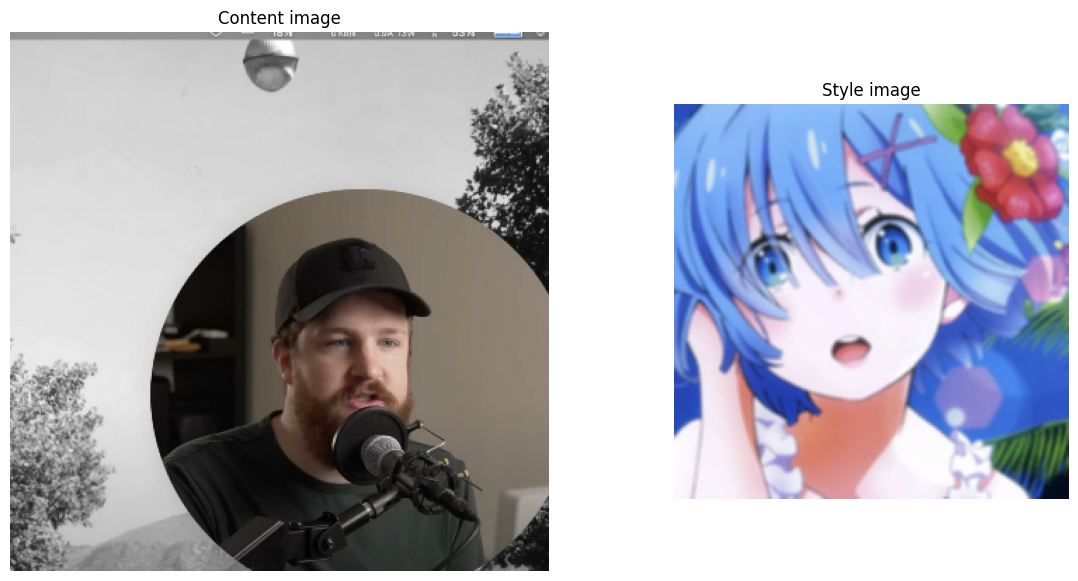

In [3]:
# @title Load example images  { display-mode: "form" }

content_image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Golden_Gate_Bridge_from_Battery_Spencer.jpg/640px-Golden_Gate_Bridge_from_Battery_Spencer.jpg'  # @param {type:"string"}
style_image_url = 'https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg'  # @param {type:"string"}
output_image_size = 384  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_content_image(content_img_size)
style_image = load_style_image(style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])

## Import TF Hub module

In [4]:
# Load TF Hub module.

hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

The signature of this hub module for image stylization is:
```
outputs = hub_module(content_image, style_image)
stylized_image = outputs[0]
```
Where `content_image`, `style_image`, and `stylized_image` are expected to be 4-D Tensors with shapes `[batch_size, image_height, image_width, 3]`.

In the current example we provide only single images and therefore the batch dimension is 1, but one can use the same module to process more images at the same time.

The input and output values of the images should be in the range [0, 1].

The shapes of content and style image don't have to match. Output image shape
is the same as the content image shape.

## Demonstrate image stylization

In [5]:
# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.

outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

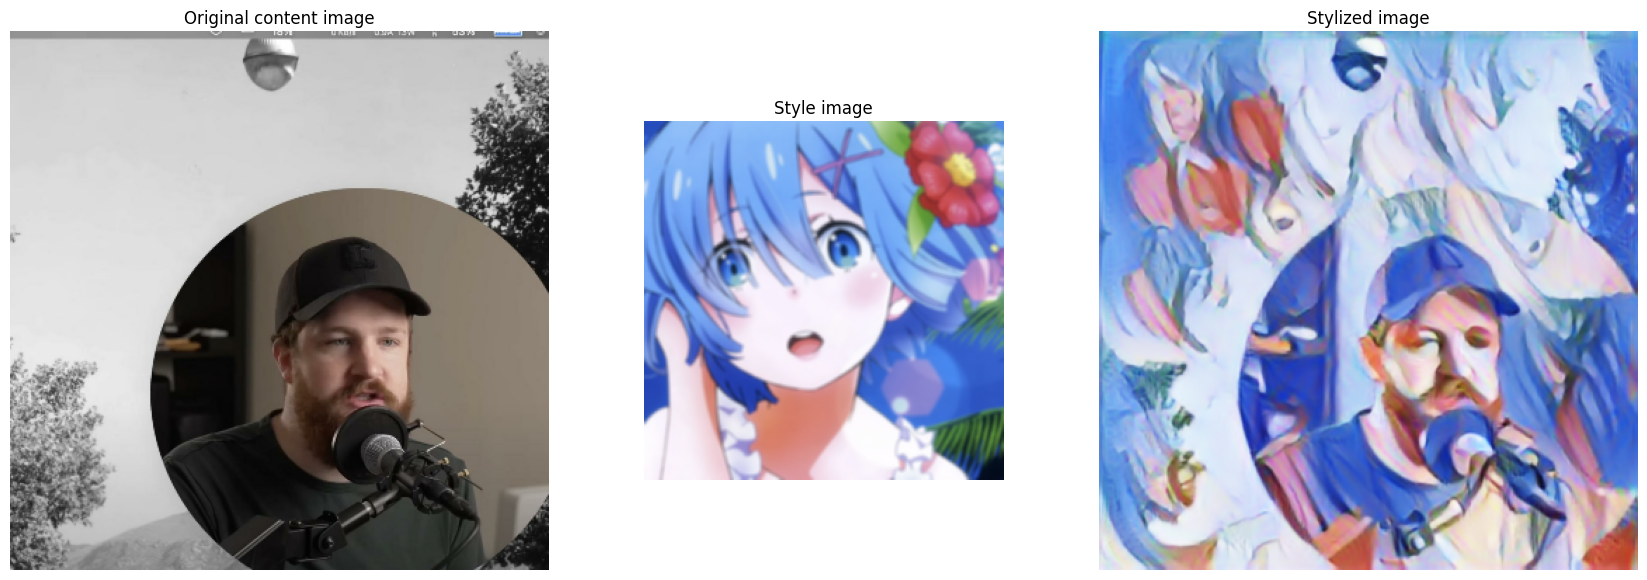

In [6]:
# Visualize input images and the generated stylized image.

show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])

## Let's try it on more images

In [7]:
!pip install anvil-uplink

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 KB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 KB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45229 sha256=90b3f425b4873f4ce46f7f8d74b3ed8bf8acf78096bcd3c238963ac16e15e9b0
  Stored in directory: /root/.cache/pip/wheels/e8/9d/fd/0a594a1bc8d493935d319ac40d64d79f5b4117ef4d37b1b678
Successfully built ws4py
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [8]:
import anvil.server
import anvil.media
import io
from PIL import *
from PIL import Image
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras.preprocessing.image import img_to_array

anvil.server.connect("R44JH6QGKIT73XC4QZLNHCBU-UOQIUCHJJMLM7C6I")

@anvil.server.callable
def super(file):
    print("Hit")
    with anvil.media.TempFile(file) as f:
        img = load_img(f)
        img_array = img_to_array(img)
        save_img('/work/Temp.jpg', img_array)
        print("Saved")
    print("Model")
    content_image = load_content_image(content_img_size)
    style_image = load_style_image(style_img_size)
    style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')

    outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
    stylized_image = outputs[0]
    show_n([stylized_image], titles=[' '])

    print("Sending")
    super_img = Image.open("/work/Final.jpg")
    name='super_img'
    bs = io.BytesIO()
    super_img.save(bs, format="JPEG")
    
    return anvil.BlobMedia("image/jpg", bs.getvalue(), name=name)

anvil.server.wait_forever()

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment" as SERVER


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fd07aeaf-c69f-4315-9f7c-727ae7b0015a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>